In [1]:
import sys
import os
sys.path.insert(0, "../../python")

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import scipy.constants as const
from scipy.special import dawsn
from scipy.special import gamma
from ionization import adk

c = const.physical_constants['speed of light in vacuum'][0]
me = const.physical_constants['electron mass'][0]
e = const.physical_constants['elementary charge'][0]
hbar = const.physical_constants['Planck constant over 2 pi'][0]
alpha = const.physical_constants['fine-structure constant'][0]

In [2]:
# Lets start with Argon
xi = 15.7596 # eV - ionization energy
Z = 1        # atomic residue
l = 1        # orbital angular momentum quantum number
lam = 0.8    # um - laser wavelength

In [3]:
# First, calculate all the parameters that depend only on the species being ionized
w = 2*np.pi*c / (lam * 1e-6)
E0 = (2*xi)**1.5 * np.sqrt(me*e) / hbar
n = alpha*c*Z*np.sqrt(me/(2*e*xi))
f = 2*l + 1
C2 = 4**n / (n*gamma(2*n))

print('omega: %.3e' % w)
print('f    : %.2f THz' % (w/1e12/2/np.pi,))
print('E0   : %.2f GV/m' % (E0/1e9))
print('n*   : %.4f' % n)
print('Cnl2 : %.4f' % C2)
print('hw   : %.4f eV' % (hbar*w/e))

omega: 2.355e+15
f    : 374.74 THz
E0   : 641.04 GV/m
n*   : 0.9292
Cnl2 : 4.1156
hw   : 1.5498 eV


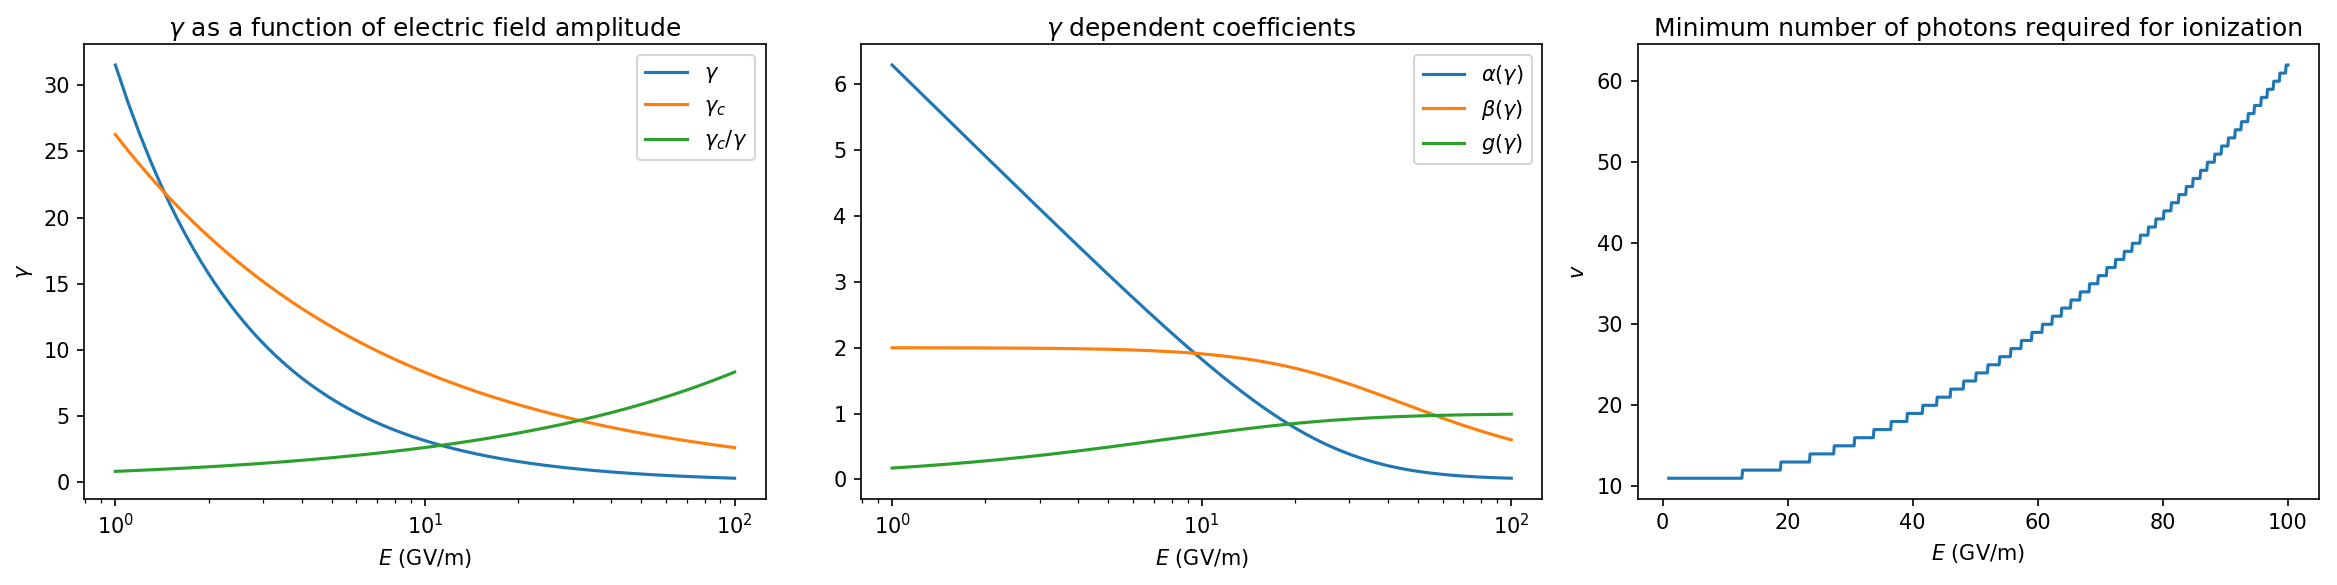

In [4]:
# Next, calculate gamma and functions of gamma for E from 1GV/m to 100GV/m
E = np.linspace(1e9, 100e9, 1000)
gamma  = (w/E) * np.sqrt(2*me*xi/e)
gammac = np.sqrt(E0/(n*E))
alpha  = 2*(np.arcsinh(gamma) - gamma/np.sqrt(1+gamma**2))
beta   = 2*gamma / np.sqrt(1+gamma**2)
g      = 3/(2*gamma) * ((1+1/(2*gamma**2))*np.arcsinh(gamma) - np.sqrt(1+gamma**2)/(2*gamma))
v      = e*xi/(hbar*w) * (1+1/(2*gamma**2))

plt.figure(figsize=(16,4), dpi=150)
gs = gridspec.GridSpec(1, 3)
plt.subplot(gs[0, 0])
plt.plot(E/1e9, gamma, E/1e9, gammac, E/1e9, gammac/gamma)
plt.title(r'$\gamma$ as a function of electric field amplitude')
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$\gamma$')
plt.legend([r'$\gamma$', r'$\gamma_c$', r'$\gamma_c/\gamma$'])
plt.xscale('log')

plt.subplot(gs[0, 1])
plt.plot(E/1e9, alpha, E/1e9, beta, E/1e9, g)
plt.title(r'$\gamma$ dependent coefficients')
plt.xlabel(r'$E$ (GV/m)')
plt.legend([r'$\alpha(\gamma)$', r'$\beta(\gamma)$', r'$g(\gamma)$'])
plt.xscale('log')

plt.subplot(gs[0, 2])
plt.plot(E/1e9, v - (v % 1) + 1)
plt.title(r'Minimum number of photons required for ionization')
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$v$')
plt.tight_layout()
plt.show()

/home/robert/anaconda3/envs/CU-PWFA/lib/python3.6/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


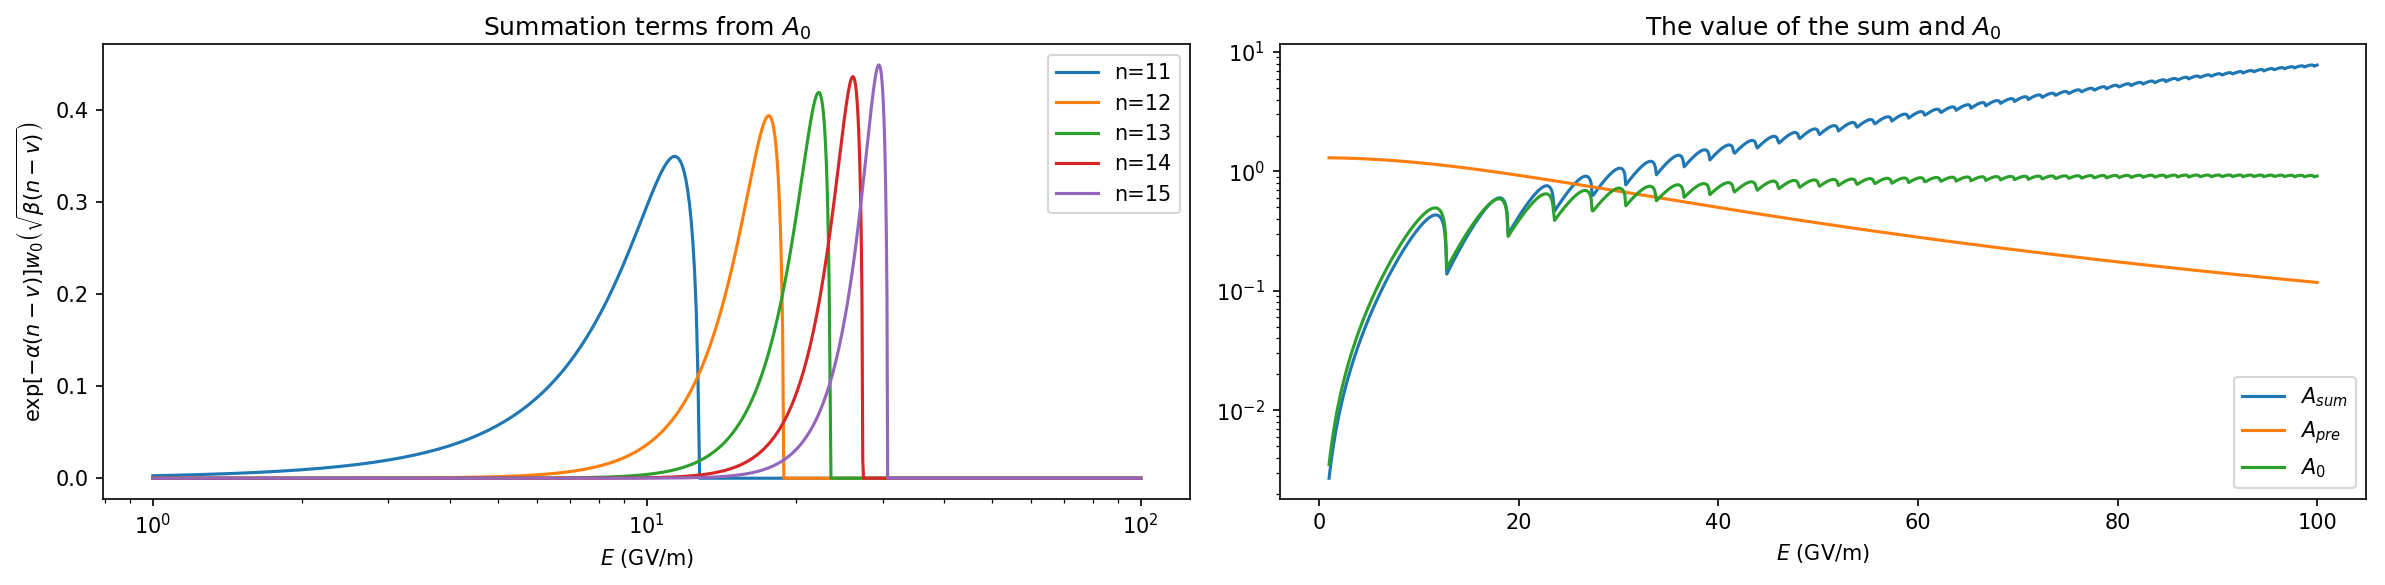

In [5]:
# Next, we calculate the first couple terms of the infinite series for MPI
Apre = 4*gamma**2/(np.sqrt(3*np.pi)*(1+gamma**2))
def An(n):
    ret =  np.exp(-alpha*(n-v))*dawsn(np.sqrt(beta*(n-v)))
    ret[n < v] = 0.0
    return ret
Asum = An(11)
for i in range(180):
    Asum += An(12+i)

plt.figure(figsize=(16,4), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0, 0])
plt.plot(E/1e9, An(11), E/1e9, An(12), E/1e9, An(13), E/1e9, An(14), E/1e9, An(15))
plt.title(r'Summation terms from $A_0$')
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$\exp[-\alpha(n-v)]w_0\left(\sqrt{\beta(n-v)}\right)$')
plt.legend(['n=11', 'n=12', 'n=13', 'n=14', 'n=15'])
plt.xscale('log')

plt.subplot(gs[0, 1])
plt.plot(E/1e9, Asum, E/1e9, Apre, E/1e9, Apre*Asum)
plt.title(r'The value of the sum and $A_0$')
plt.xlabel(r'$E$ (GV/m)')
plt.legend([r'$A_{sum}$', r'$A_{pre}$', r'$A_0$'])
plt.yscale('log')

plt.tight_layout()
plt.show()

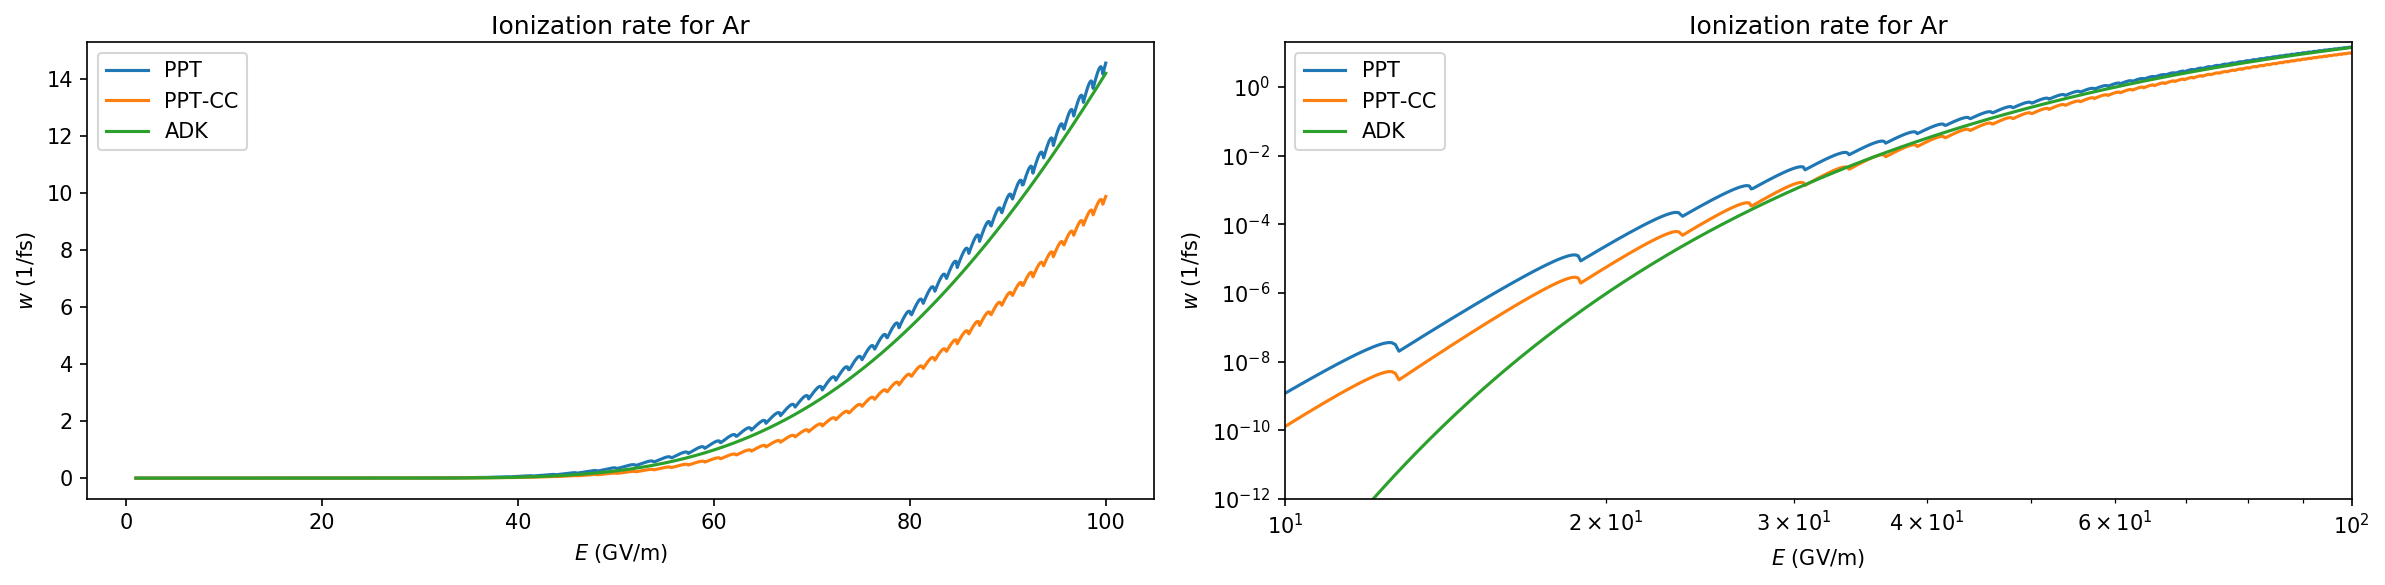

In [6]:
# Put it all together to find the ionization rate
ratePPT = C2*e/hbar*np.sqrt(6/np.pi)*(2*l+1)*xi \
          *(2*E0/E)**(2*n-1.5)*(1+gamma**2)**0.75 \
          *Apre*Asum*np.exp(-2*E0*g/(3*E))/1e15
        
rateADK = C2*e/hbar*np.sqrt(6/np.pi)*(2*l+1)*xi \
          *(2*E0/E)**(2*n-1.5)*np.exp(-2*E0/(3*E))/1e15

# This is jus a sanity check but it is indeed the same as rateADK
rateADK2 = adk.rate_linear(xi, E/1e9, 1, 1, 0)

ratePPTCC = ratePPT * (1 + 2*gamma/np.exp(1))**(-2*n)

plt.figure(figsize=(16,4), dpi=150)
gs = gridspec.GridSpec(1, 2)
plt.subplot(gs[0, 0])
plt.plot(E/1e9, ratePPT, E/1e9, ratePPTCC, E/1e9, rateADK)
plt.title(r'Ionization rate for Ar')
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$w$ (1/fs)')
plt.legend(['PPT', 'PPT-CC', 'ADK'])

plt.subplot(gs[0, 1])
plt.plot(E/1e9, ratePPT, E/1e9, ratePPTCC, E/1e9, rateADK)
plt.title(r'Ionization rate for Ar')
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$w$ (1/fs)')
plt.legend(['PPT', 'PPT-CC', 'ADK'])
plt.xscale('log')
plt.yscale('log')
plt.xlim([10, 100])
plt.ylim([1e-12, 20])

plt.tight_layout()
plt.show()

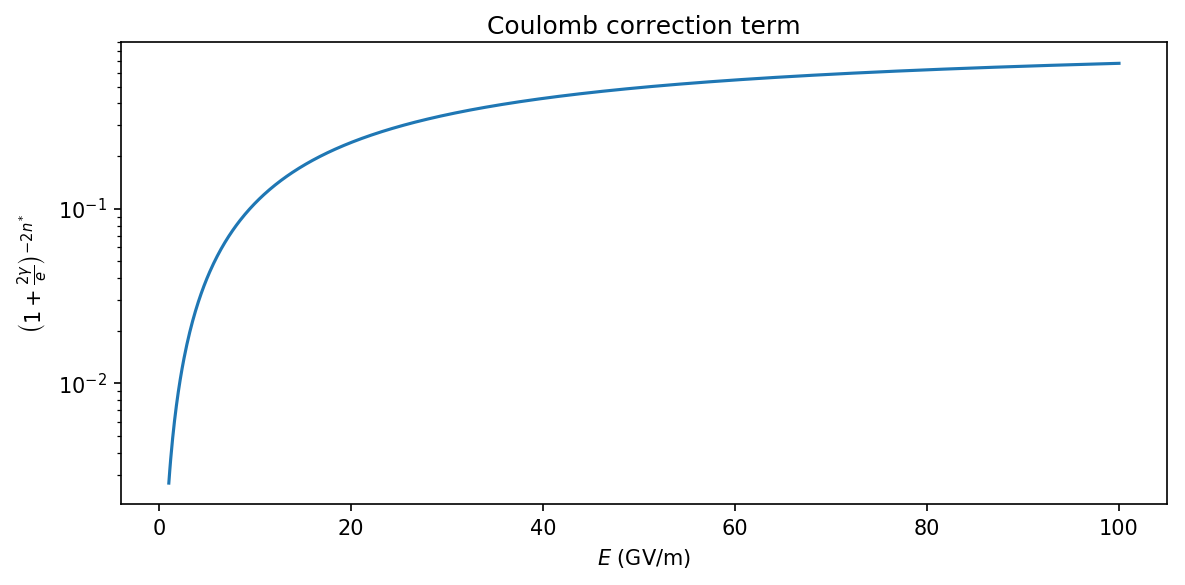

In [7]:
# The really important thing for the CC is the relative size to the ionization rate
plt.figure(figsize=(8,4), dpi=150)
gs = gridspec.GridSpec(1, 1)
plt.subplot(gs[0, 0])
plt.plot(E/1e9, (1 + 2*gamma/np.exp(1))**(-2*n))
plt.title(r'Coulomb correction term')
plt.xlabel(r'$E$ (GV/m)')
plt.ylabel(r'$\left(1 + \frac{2\gamma}{e}\right)^{-2n^*}$')
plt.yscale('log')
#plt.xscale('log')
plt.tight_layout()
plt.show()